<a href="https://colab.research.google.com/github/Paradiddle131/Cigarette-Detecting-and-Blurring-Using-Mask-RCNN/blob/master/CigBlur_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Download Data**

#### From floydhub.com

In [0]:
!pip install floyd-cli
!floyd login

In [0]:
%cd /content
!mkdir -p cigarette
%cd cigarette
!floyd data clone paradiddle131/datasets/cigarette_456_1024x1024
%cd /content

#### From Ensar's Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!mkdir cigarette
%cd cigarette
!mkdir images
!mkdir annots

In [0]:
!cp -avr /content/drive/My\ Drive/Cigarette_Detection/Data/train/* /content/cigarette/images
!cp -avr /content/drive/My\ Drive/Cigarette_Detection/Data/test/* /content/cigarette/images

!cp -avr /content/drive/My\ Drive/Cigarette_Detection/Data/Annotations/train/* /content/cigarette/annots
!cp -avr /content/drive/My\ Drive/Cigarette_Detection/Data/Annotations/test/* /content/cigarette/annots

## **Import Libraries**

In [0]:
import os 
import cv2
import glob
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import xml.etree.ElementTree as ET
from PIL import Image, ImageOps

## **Analyze Images' Shapes**

In [0]:
path = '/content/cigarette/images'
shapes_list = []
shapes_dict = {}
for file in os.listdir(path):
  img = cv2.imread(f'{path}/{file}', 0)
  shapes_list.append(img.shape)
  shapes_dict.update({file: img.shape})

In [0]:
shapes = pd.DataFrame(shapes_list)
shapes

,0,1
0,264,767
1,209,372
2,668,1000
3,225,345
4,737,751
...,...,...
726,1200,1600
727,360,480
728,450,800
729,200,250


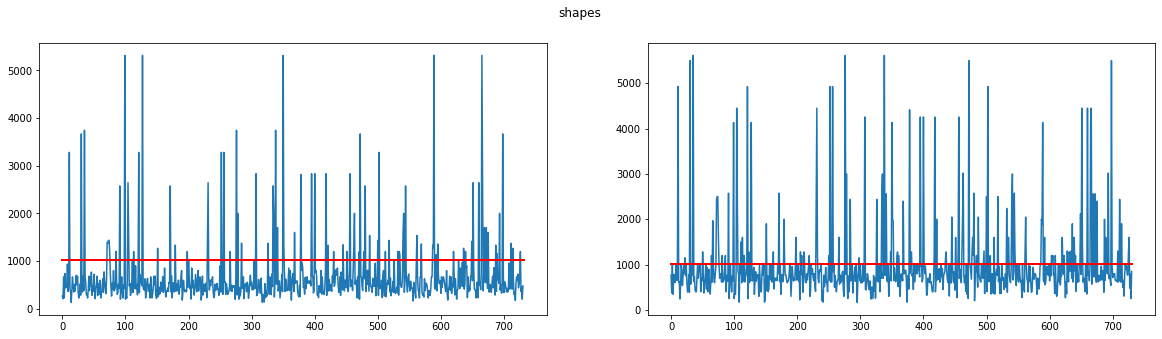

In [0]:
columns = shapes.columns
x_data = range(0, shapes.shape[0])
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20,5)
fig.suptitle('shapes')

ax1.plot(x_data, shapes[0], label=1)
ax2.plot(x_data, shapes[1], label=2)
ax1.plot([0, shapes.shape[0]], [1024, 1024], color='r', linestyle='-', linewidth=2)
ax2.plot([0, shapes.shape[0]], [1024, 1024], color='r', linestyle='-', linewidth=2)

In [0]:
print(f'Min x: {min(shapes[0])}')
print(f'Min y: {min(shapes[1])}')
print(f'Max x: {max(shapes[0])}')
print(f'Max y: {max(shapes[1])}')

Min x: 131
Min y: 165
Max x: 5315
Max y: 5616


In [0]:
path = '/content/cigarette/images'
count = 0
exceeds_1024_list = []
for file in os.listdir(path):
  if shapes_dict[file][0] > 1024 or shapes_dict[file][1] > 1024:
    # print(file, "exceeds 1024x1024")
    count += 1
    exceeds_1024_list.append(file)
print('total images exceeding 1024x1024 resolution:', count)

total images exceeding 1024x1024 resolution: 136


### Shapes Before Resize

In [0]:
path1 = '/content/cigarette_w_annots/cigarette/ch_00000000.jpg'
path2 = '/content/cigarette_w_annots/cigarette/ru_00000199.jpg'
path3 = '/content/cigarette_w_annots/cigarette/ita_00000076.jpg'
path4 = '/content/cigarette_w_annots/cigarette/ita_00000005.jpg'
img = cv2.imread(path, 0)
print(path, img.shape)
img = cv2.imread(path2, 0)
print(path2, img.shape)
img = cv2.imread(path3, 0)
print(path3, img.shape)
img = cv2.imread(path4, 0)
print(path4, img.shape)

/content/cigarette_w_annots/cigarette/ch_00000000.jpg (202, 220)
/content/cigarette_w_annots/cigarette/ru_00000199.jpg (853, 1280)
/content/cigarette_w_annots/cigarette/ita_00000076.jpg (682, 1024)
/content/cigarette_w_annots/cigarette/ita_00000005.jpg (1702, 2560)


## **Crop Only Annotated Parts**

### Extract Coordinates

In [0]:
%cd /content/cigarette/annots
dict_coor = {}
count = 0
for filepath in os.listdir():
  with open(filepath) as fp:
    try:
      xs = fp.readlines()
      img_name = xs[3].split("</path>")[0].split("\\")[-1]
      xmin = str(xs[19].split("<xmin>")[1].split('<')[0])
      ymin = str(xs[20].split("<ymin>")[1].split('<')[0])
      xmax = str(xs[21].split("<xmax>")[1].split('<')[0])
      ymax = str(xs[22].split("<ymax>")[1].split('<')[0])
      dict_coor.update({img_name:{'xmin':xmin, 'ymin':ymin, 'xmax':xmax, 'ymax':ymax}})
      count += 1
      if count == 9999:
        break
    except:
      print('No coordinates found for: ', img_name)
%cd /content

/content/cigarette/annots
No coordinates found for:  sp_00000201.jpg
No coordinates found for:  ger_00000255.jpg
No coordinates found for:  ch_00000393.jpg
No coordinates found for:  ger_00000247.jpg
No coordinates found for:  ko_00000410.png
No coordinates found for:  ru_00000027.jpeg
No coordinates found for:  ita_00000219.jpg
No coordinates found for:  ch_00000074.jpg
/content


In [0]:
len(dict_coor)

747

### Crop

#### Single Example

(1702, 2560, 3)
{'xmin': '1042', 'ymin': '223', 'xmax': '1755', 'ymax': '1031'}
1042 223 1755 1031
(808, 713, 3)


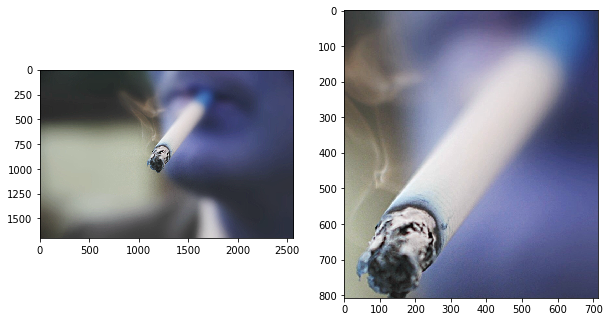

In [0]:
pth = '/content/ita_00000005.jpg'
img_name = pth.split('/')[-1]
img = cv2.imread(pth)
print(img.shape)
fig = plt.figure(figsize=(10, 20))
fig.add_subplot(1, 2, 1)
plt.imshow(img)
print(dict_coor[img_name])
xmin, ymin, xmax, ymax = dict_coor[img_name].values()
xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
print(xmin, ymin, xmax, ymax)
img = img[ymin:ymax, xmin:xmax]
print(img.shape)
fig.add_subplot(1, 2, 2)
plt.imshow(img)
plt.show()

#### Whole Dataset

In [0]:
def crop_annot(img_path, copy_path):
  img_name = img_path.split('/')[-1]
  img = cv2.imread(img_path)
  xmin, ymin, xmax, ymax = dict_coor[img_name].values()
  xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
  img = img[ymin:ymax, xmin:xmax]
  return img

In [0]:
source = '/content/cigarette/images'
target = '/content/cigarette_cropped'
!mkdir -p {target}
%cd {target}
!mkdir images
%cd images
for file in os.listdir(source):
  try:
    img = crop_annot(f'{source}/{file}', f'{target}/images/{file}')
    cv2.imwrite(file, img)
  except:
    print('No coordinates found for: ', file)
%cd /content

/content/cigarette_cropped
mkdir: cannot create directory ‘images’: File exists
/content/cigarette_cropped/images
No coordinates found for:  ita_00000219.jpg
No coordinates found for:  ru_00000027.jpg
No coordinates found for:  ko_00000410.png
No coordinates found for:  ger_00000255.jpg
No coordinates found for:  sp_00000201.jpg
No coordinates found for:  ger_00000247.jpg
No coordinates found for:  ch_00000074.jpg
No coordinates found for:  ch_00000393.jpg
No coordinates found for:  ru_00000027.jpeg
/content


### Update XML Files

In [0]:
def update_xml(xml_path, output_path):
  try:
    tree = ET.parse(xml_path)
    root = tree.getroot()
    width = root[4][0].text
    height = root[4][1].text
    root[6][4][0].text = str(0)
    root[6][4][1].text = str(0)
    root[6][4][2].text = width
    root[6][4][3].text = height
    tree.write(os.path.join(output_path, xml_path.split('/')[-1]))
  except:
    print(f"Can't reach the child of {xml_path.split('/')[-1]}")

In [0]:
%cd /content
!mkdir -p cigarette_modified
%cd /content/cigarette_modified
!mkdir -p annots
%cd /content

In [0]:
path = '/content/cigarette/annots'
output_path = '/content/cigarette_modified/annots'
for file in os.listdir(path):
  update_xml(os.path.join(path, file), output_path)

Can't reach the child of sp_00000201.xml
Can't reach the child of ger_00000255.xml
Can't reach the child of .floyddata
Can't reach the child of ch_00000393.xml
Can't reach the child of ger_00000247.xml
Can't reach the child of ko_00000410.xml
Can't reach the child of ru_00000027.xml
Can't reach the child of ita_00000219.xml
Can't reach the child of ch_00000074.xml


## **Modifying**

### Resize

#### Single Example

(1702, 2560)

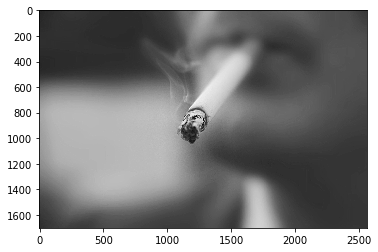

In [0]:
img = cv2.imread('/content/ita_00000005.jpg', 0)
plt.imshow(img, 'gray')
img.shape

ita_00000005.jpg (1702, 2560)
ita_00000005_resized.jpg (1024, 1024)
(1702, 2560)
(1024, 1024)


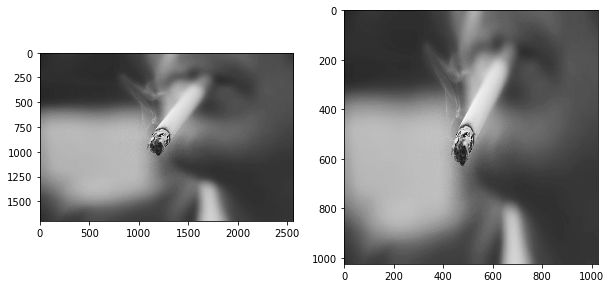

In [0]:
file = 'ita_00000005.jpg'
img = cv2.imread(f'/content/{file}', 0)
print(file, img.shape)
img_resized = cv2.resize(img, (1024,1024))
newname = f'{file.split(".")[0]}_resized.{file.split(".")[1]}'
print(newname, img_resized.shape)
print(img.shape)
print(img_resized.shape)

fig = plt.figure(figsize=(10, 20))
fig.add_subplot(1, 2, 1)
plt.imshow(img, 'gray')
fig.add_subplot(1, 2, 2)
plt.imshow(img_resized, 'gray')
plt.show()

#### Whole Dataset

In [0]:
def resize(img, target_size):
  img_resized = cv2.resize(img, (target_size[0], target_size[1]))
  return img_resized

### Expand

#### Single Example

before (202, 220)
(411, 411) (402, 402)
after (1024, 1024)


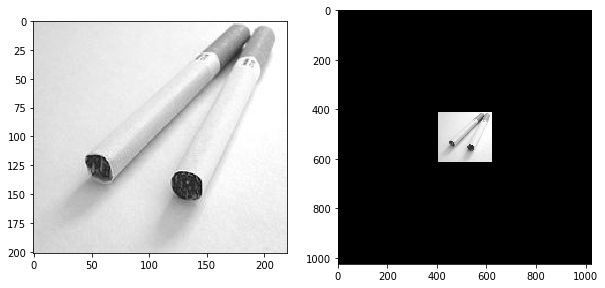

In [0]:
path1 = '/content/cigarette/images/ch_00000000.jpg'
img = cv2.imread(path1, 0)
print('before', img.shape)
# img_exp = np.pad(img, [(0, 1024-img.shape[0]), (0, 1024-img.shape[1])], mode='constant', constant_values=0)
target_size = 1024
x_pad = (round((target_size - img.shape[0])/2), round((target_size - img.shape[0])/2))
y_pad = (round((target_size - img.shape[1])/2), round((target_size - img.shape[1])/2))
print(x_pad, y_pad)
img_exp = np.pad(img, [x_pad, y_pad], mode='constant', constant_values=0)
print('after', img_exp.shape)

fig = plt.figure(figsize=(10, 20))
fig.add_subplot(1, 2, 1)
plt.imshow(img, 'gray')
fig.add_subplot(1, 2, 2)
plt.imshow(img_exp, 'gray')
plt.show()

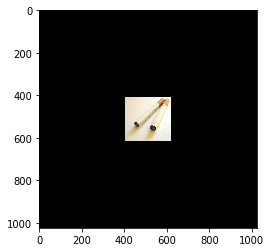

In [0]:
path1 = '/content/cigarette/images/ch_00000000.jpg'
target_size = (1024, 1024)
img = cv2.imread(path1)
tmp = expand(img, target_size)
tmp = cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB)
plt.imshow(tmp)

#### Whole Dataset

In [0]:
def expand(img, target_size):
  if img.shape[0] < target_size[0]:
    w = img.shape[0]
  else:
    w = target_size[0]
  if img.shape[1] < target_size[1]:
    h = img.shape[1]
  else:
    h = target_size[1]
  x_pad = (math.floor((target_size[0] - w)/2), math.ceil((target_size[0] - w)/2))
  y_pad = (math.floor((target_size[1] - h)/2), math.ceil((target_size[1] - h)/2))
  img_expanded = np.stack([np.pad(img[:,:,x], [x_pad, y_pad], mode='constant', constant_values=0) for x in range(3)], axis=2)
  # img_expanded = np.stack([np.pad(img[:,:,x], [(0, target_size[0]-w), 
  #                (0, target_size[1]-h)], mode='constant', constant_values=0) for x in range(3)], axis=2)
  return img_expanded

In [0]:
img = cv2.imread('/content/cigarette_133/23.jpg')
img = expand(img, target_size)
img.shape

(366, 555, 3)
(329, 329) (234, 235)


(1024, 1024, 3)

## **Equalizing all images at (1024, 1024)**

In [0]:
def equalize(path, target_size, target_path):
  img = cv2.imread(path)
  try:
    if (img.shape[0] < target_size[0] and img.shape[1] < target_size[1]) or (
        img.shape[0] == target_size[0] and img.shape[1] < target_size[1]) or (
            img.shape[0] < target_size[0] and img.shape[1] == target_size[1]):
      img_modified = expand(img, target_size)
    elif (img.shape[0] < target_size[0] and img.shape[1] > target_size[1]) or (
        img.shape[0] > target_size[0] and img.shape[1] < target_size[1]):
      img_modified = expand(img, target_size)
      img_modified = resize(img, target_size)
    elif (img.shape[0] > target_size[0] and img.shape[1] > target_size[1]) or (
        img.shape[0] == target_size[0] and img.shape[1] > target_size[1]) or (
            img.shape[0] > target_size[0] and img.shape[1] == target_size[1]):
      img_modified = resize(img, target_size)
    elif (img.shape[0] == target_size[0] and img.shape[1] == target_size[1]):
      img_modified = img
  except: 
    print('ANOTHER CASE HAS BEEN ENCOUNTERED! FOR:', path)

  cv2.imwrite(target_path, img_modified)

In [0]:
%cd /content
!mkdir -p cigarette_modified
%cd cigarette_modified
!mkdir -p images
%cd /content

Equalizing

In [0]:
path = '/content/cigarette/images'
target_size = (1024, 1024)
target_path = '/content/cigarette_modified/images'

for file in os.listdir(path):
  if '.ipynb_checkpoints' not in file:
    try:
      equalize(path+'/'+file, target_size, target_path+'/'+file)
    except:
      print(f"Error: Couldn't equalize {file}.")

Check new shapes

In [0]:
path = '/content/sample_50/images'
for f in os.listdir(path):
  print(cv2.imread(path+'/'+f).shape)

In [0]:
path = '/content/sample_50/images'
for f in os.listdir(path):
  try:
    if 39 < int(f.split('.')[0]) < 50:
      # print(f.split('.')[0])
      !mv {path+'/'+f} /content/sample_50/val
  except:
    pass

## **Check Image Sameness**

In [0]:
sames = {}
checked = []

def check_sameness(source_path, target_path):
  all_images_to_compare = []
  titles = []
  for f in glob.iglob(source_path+'/*'):
      image = cv2.imread(f)
      titles.append(f)
      all_images_to_compare.append(image)

  all_target_images = []
  target_titles = []
  for f in glob.iglob(target_path+'/*'):
      image = cv2.imread(f)
      target_titles.append(f)
      all_target_images.append(image)
    
  global sames
  global checked
  count = 0

  _, _, files = next(os.walk(source_path))
  file_count = len(files)

  for i, (original, title) in enumerate(zip(all_images_to_compare, titles)):
    sames_list = []
    for j, (image_to_compare, title) in enumerate(zip(all_target_images, target_titles)):
      if original.shape == image_to_compare.shape:
        difference = cv2.subtract(original, image_to_compare)
        b, g, r = cv2.split(difference)
        try:
          if cv2.countNonZero(b) == 0 and cv2.countNonZero(g) == 0 and \
          cv2.countNonZero(r) == 0: # and titles[j].split('/')[-1] not in checked:
              sames_list.append(target_titles[j].split('/')[-1])
              sames.update({i: {titles[i].split('/')[-1]:sames_list}})
              count += 1 
        except:
          continue
    checked.append(target_titles[i].split('/')[-1])
  return f"There are {count} duplicate images out of {file_count}."

In [0]:
source_path = '/content/cigarette/images'
target_path = '/content/cigarette_target/images'

check_sameness(source_path, target_path)

In [0]:
sames

{10: {'91.cigarette_smoking_tobacco_secondhand_-_phonrat_shutterstock.jpg': ['en_00000208.jpg']},
 12: {'45.cropped-hand-of-woman-smoking-cigarette-970153368-5b395478c9e77c001a294ae8.jpg': ['en_00000085.jpg']},
 30: {'52.india-smoking.jpg': ['en_00000150.jpg']},
 34: {'6.650x350_listicle_cigarette_effects_video.jpg': ['en_00000471.jpg']},
 41: {'14.smoking.jpg': ['en_00000314.jpg']},
 55: {'12.Screen-Shot-2019-04-09-at-9.42.05-PM.png': ['en_00000009.png']},
 59: {'25.cropped-image-of-person-smoking-cigarette-636720881-57328d125f9b58723d81d0d8.jpg': ['en_00000113.jpg']},
 63: {'27.shutterstock_152877845.jpg': ['en_00000181.jpg']},
 75: {'4.151331783.jpg': ['en_00000021.jpg']},
 78: {'91.3388-hand_holding_cigarette-732x549-thumbnail.jpg': ['en_00000186.jpg']},
 90: {'40.3388-hand_holding_cigarette-732x549-thumbnail.jpg': ['en_00000186.jpg']},
 95: {'34.141230-smoking-cigarette-mn-1300_8b702aa3aaf40f9e22e907f32d42e019.jpg': ['en_00000211.jpg']},
 101: {'23.150513-smoking-cigarette-jpo-508

In [0]:
for file in sames.values():
  print(file)

{'91.cigarette_smoking_tobacco_secondhand_-_phonrat_shutterstock.jpg': ['en_00000208.jpg']}
{'45.cropped-hand-of-woman-smoking-cigarette-970153368-5b395478c9e77c001a294ae8.jpg': ['en_00000085.jpg']}
{'52.india-smoking.jpg': ['en_00000150.jpg']}
{'6.650x350_listicle_cigarette_effects_video.jpg': ['en_00000471.jpg']}
{'14.smoking.jpg': ['en_00000314.jpg']}
{'12.Screen-Shot-2019-04-09-at-9.42.05-PM.png': ['en_00000009.png']}
{'25.cropped-image-of-person-smoking-cigarette-636720881-57328d125f9b58723d81d0d8.jpg': ['en_00000113.jpg']}
{'27.shutterstock_152877845.jpg': ['en_00000181.jpg']}
{'4.151331783.jpg': ['en_00000021.jpg']}
{'91.3388-hand_holding_cigarette-732x549-thumbnail.jpg': ['en_00000186.jpg']}
{'40.3388-hand_holding_cigarette-732x549-thumbnail.jpg': ['en_00000186.jpg']}
{'34.141230-smoking-cigarette-mn-1300_8b702aa3aaf40f9e22e907f32d42e019.jpg': ['en_00000211.jpg']}
{'23.150513-smoking-cigarette-jpo-508p_d58f1abb2c671a81b2ebca7a28816dc3.fit-760w.jpg': ['en_00000011.jpg']}
{'46.46

In [0]:
lst = ['91.cigarette_smoking_tobacco_secondhand_-_phonrat_shutterstock.jpg',
'45.cropped-hand-of-woman-smoking-cigarette-970153368-5b395478c9e77c001a294ae8.jpg',
'52.india-smoking.jpg',
'6.650x350_listicle_cigarette_effects_video.jpg',
'14.smoking.jpg',
'12.Screen-Shot-2019-04-09-at-9.42.05-PM.png',
'25.cropped-image-of-person-smoking-cigarette-636720881-57328d125f9b58723d81d0d8.jpg',
'27.shutterstock_152877845.jpg',
'4.151331783.jpg',
'91.3388-hand_holding_cigarette-732x549-thumbnail.jpg',
'40.3388-hand_holding_cigarette-732x549-thumbnail.jpg',
'34.141230-smoking-cigarette-mn-1300_8b702aa3aaf40f9e22e907f32d42e019.jpg',
'23.150513-smoking-cigarette-jpo-508p_d58f1abb2c671a81b2ebca7a28816dc3.fit-760w.jpg',
'46.4662065_111018-wabc-shutterstock-cigarette-smoking-img.jpg',
'19.cigarette_smoke-56b368813df78cdfa004d004.jpg']

In [0]:
%cd /content/drive/My Drive/Bilim Icin Sigara Icin/eldesigara-emre
!ls | wc -l
%cd /content

/content/drive/My Drive/Bilim Icin Sigara Icin/eldesigara-emre
148
/content


In [0]:
for file in glob.glob('/content/drive/My Drive/Bilim Icin Sigara Icin/eldesigara-emre/*'):
  filename = file.split('/')[-1]
  if filename in lst:
    print(filename)
    !rm -fr /content/drive/My\ Drive/Bilim\ Icin\ Sigara\ Icin/eldesigara-emre/{filename}

45.cropped-hand-of-woman-smoking-cigarette-970153368-5b395478c9e77c001a294ae8.jpg
91.cigarette_smoking_tobacco_secondhand_-_phonrat_shutterstock.jpg
52.india-smoking.jpg
25.cropped-image-of-person-smoking-cigarette-636720881-57328d125f9b58723d81d0d8.jpg
23.150513-smoking-cigarette-jpo-508p_d58f1abb2c671a81b2ebca7a28816dc3.fit-760w.jpg
14.smoking.jpg
91.3388-hand_holding_cigarette-732x549-thumbnail.jpg
12.Screen-Shot-2019-04-09-at-9.42.05-PM.png
46.4662065_111018-wabc-shutterstock-cigarette-smoking-img.jpg
34.141230-smoking-cigarette-mn-1300_8b702aa3aaf40f9e22e907f32d42e019.jpg
40.3388-hand_holding_cigarette-732x549-thumbnail.jpg
6.650x350_listicle_cigarette_effects_video.jpg
19.cigarette_smoke-56b368813df78cdfa004d004.jpg
27.shutterstock_152877845.jpg
4.151331783.jpg


In [0]:
%cd /content/drive/My Drive/Bilim Icin Sigara Icin/eldesigara-emre
!ls | wc -l
%cd /content

/content/drive/My Drive/Bilim Icin Sigara Icin/eldesigara-emre
133
/content


In [0]:
%cd /content/cigarette/images
!ls | wc -l
%cd /content

/content/cigarette/images
323
/content


In [0]:
name = '34.141230-smoking-cigarette-mn-1300_8b702aa3aaf40f9e22e907f32d42e019.jpg'
out = name.split('jpg')[-2]
out

'34.141230-smoking-cigarette-mn-1300_8b702aa3aaf40f9e22e907f32d42e019.'

In [0]:
!cp -avr /content/drive/My\ Drive/Bilim\ Icin\ Sigara\ Icin/eldesigara-emre/* /content/tmp/img

In [0]:
!cp -avr /content/tmp/img/* /content/cigarette/images

In [0]:
path = '/content/cigarette_133'
count = 0
for file in os.listdir(path):
  src = path+'/'+file
  dst = path+'/'+str(count)+'.jpg'
  print(src,'\n',dst)
  os.rename(src, dst)
  count += 1

In [0]:
path = '/content/cigarette/images'

for file in os.listdir(path):
  img = cv2.imread(path+'/'+file)
  print(img.shape)
  break

(667, 1000, 3)


In [0]:
%cd /content/cigarette_modified/images/
!ls | wc -l 
%cd /content

/content/cigarette_modified/images
133
/content
